# Product Engagement Prediction - MLOps Pipeline

## MLOps Assignment Implementation

**Student:** [Lievin Murayire]  

---

## Project Overview

This project implements a complete MLOps pipeline for predicting product engagement using computer vision. The pipeline focuses on the five core MLOps processes required for the assignment:

### MLOps Pipeline Components

- **Data Acquisition** - Automated data collection and validation
- **Data Processing** - Image preprocessing and augmentation pipeline  
- **Model Creation** - CNN architecture design and training
- **Model Testing** - Comprehensive model evaluation and validation
- **Model Retraining** - Automated retraining system with performance triggers

---

## Dataset Information

**Current Dataset:**
- **Training Images:** 12 total (6 high engagement + 6 low engagement)
- **Testing Images:** 8 total (4 high engagement + 4 low engagement)
- **Image Size:** 224x224 pixels
- **Format:** JPG product images

**Business Context:** Predicting whether product images will generate high or low customer engagement based on visual features.

In [67]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras import regularizers

import cv2
from PIL import Image, ImageEnhance
import albumentations as A

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import json
import pickle
import requests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"OpenCV version: {cv2.__version__}")

TensorFlow version: 2.19.0
GPU Available: False
OpenCV version: 4.12.0


# Data Acquisition & Setup

Setting up the project structure and implementing data acquisition process for MLOps pipeline.

In [68]:
# Project setup and configuration
BASE_DIR = Path(r"c:\Users\HP\Documents\Summative-assignment---MLOP")
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"

# Create directory structure for image data
train_high = DATA_DIR / "train" / "high_engagement"
train_low = DATA_DIR / "train" / "low_engagement"
test_high = DATA_DIR / "test" / "high_engagement"
test_low = DATA_DIR / "test" / "low_engagement"

# Ensure directories exist
for dir_path in [train_high, train_low, test_high, test_low, MODELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Model configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print("Project directories created:")
print(f"├── {DATA_DIR}")
print(f"│   ├── train/high_engagement/ ({len(list(train_high.glob('*')))} images)")
print(f"│   ├── train/low_engagement/ ({len(list(train_low.glob('*')))} images)")
print(f"│   ├── test/high_engagement/ ({len(list(test_high.glob('*')))} images)")
print(f"│   └── test/low_engagement/ ({len(list(test_low.glob('*')))} images)")
print(f"└── {MODELS_DIR}")

Project directories created:
├── c:\Users\HP\Documents\Summative-assignment---MLOP\data
│   ├── train/high_engagement/ (6 images)
│   ├── train/low_engagement/ (6 images)
│   ├── test/high_engagement/ (4 images)
│   └── test/low_engagement/ (4 images)
└── c:\Users\HP\Documents\Summative-assignment---MLOP\models


In [69]:
# Data Acquisition Process

def acquire_product_data():
    """
    Data acquisition process for product engagement prediction.
    
    Dataset Structure:
    - Training: 6 high engagement + 6 low engagement images
    - Testing: 4 high engagement + 4 low engagement images
    
    This represents real-world product images from e-commerce catalog.
    """
    
    # Verify directory structure
    directories = [train_high, train_low, test_high, test_low]
    for directory in directories:
        directory.mkdir(parents=True, exist_ok=True)
    
    # Count current images
    actual_counts = {
        'train_high': len(list(train_high.glob('*.jpg'))),
        'train_low': len(list(train_low.glob('*.jpg'))),
        'test_high': len(list(test_high.glob('*.jpg'))),
        'test_low': len(list(test_low.glob('*.jpg')))
    }
    
    print("Current Dataset Status:")
    print(f"  Training Images:")
    print(f"    - High Engagement: {actual_counts['train_high']} images")
    print(f"    - Low Engagement: {actual_counts['train_low']} images")
    print(f"  Testing Images:")
    print(f"    - High Engagement: {actual_counts['test_high']} images")
    print(f"    - Low Engagement: {actual_counts['test_low']} images")
    
    total_images = sum(actual_counts.values())
    print(f"  Total Dataset: {total_images} images")
    
    if total_images > 0:
        print("\nData acquisition complete - using real product images")
    else:
        print("\nNo images found - please add product images to the directories above")
    
    return actual_counts

# Execute data acquisition
dataset_info = acquire_product_data()

Current Dataset Status:
  Training Images:
    - High Engagement: 0 images
    - Low Engagement: 0 images
  Testing Images:
    - High Engagement: 1 images
    - Low Engagement: 0 images
  Total Dataset: 1 images

Data acquisition complete - using real product images


# 2️⃣ Data Processing Pipeline

Implementing robust image preprocessing and augmentation for the CNN model training process.

In [70]:
# Data Processing Pipeline Configuration

def setup_data_processing():
    """
    Configure data processing pipeline with augmentation strategies.
    Handles the transformation of raw images into model-ready format.
    """
    
    # Training data augmentation (to improve model generalization)
    train_datagen = ImageDataGenerator(
        rescale=1./255,              # Normalize pixel values
        rotation_range=20,           # Random rotation
        width_shift_range=0.2,       # Random horizontal shift
        height_shift_range=0.2,      # Random vertical shift
        shear_range=0.2,            # Random shearing
        zoom_range=0.2,             # Random zoom
        horizontal_flip=True,        # Random horizontal flip
        brightness_range=[0.8, 1.2], # Random brightness adjustment
        fill_mode='nearest',         # Fill strategy for augmentations
        validation_split=0.2         # Reserve 20% for validation
    )
    
    # Test data processing (no augmentation, only normalization)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    return train_datagen, test_datagen

def create_data_generators():
    """
    Create data generators for training and testing with proper directory structure.
    """
    train_datagen, test_datagen = setup_data_processing()
    
    # Training data generator (with validation split)
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR / "train",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )
    
    # Validation data generator
    validation_generator = train_datagen.flow_from_directory(
        DATA_DIR / "train", 
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )
    
    # Test data generator
    test_generator = test_datagen.flow_from_directory(
        DATA_DIR / "test",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Keep order for evaluation
    )
    
    return train_generator, validation_generator, test_generator

# Initialize data processing pipeline
print("🔧 Setting up data processing pipeline...")
train_gen, val_gen, test_gen = create_data_generators()

print(f"✅ Data processing pipeline configured:")
print(f"   📊 Target size: {IMG_SIZE}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   🔄 Augmentation: rotation, shift, zoom, flip, brightness")
print(f"   📈 Training samples: {train_gen.samples}")
print(f"   ✅ Validation samples: {val_gen.samples}")
print(f"   🧪 Test samples: {test_gen.samples}")

🔧 Setting up data processing pipeline...
Found 10 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
✅ Data processing pipeline configured:
   📊 Target size: (224, 224)
   📦 Batch size: 32
   🔄 Augmentation: rotation, shift, zoom, flip, brightness
   📈 Training samples: 10
   ✅ Validation samples: 2
   🧪 Test samples: 8
Found 8 images belonging to 2 classes.
✅ Data processing pipeline configured:
   📊 Target size: (224, 224)
   📦 Batch size: 32
   🔄 Augmentation: rotation, shift, zoom, flip, brightness
   📈 Training samples: 10
   ✅ Validation samples: 2
   🧪 Test samples: 8


# Data Analysis & Visualization

Understanding the dataset distribution and characteristics before model training.

🔍 Analyzing your current dataset...
Dataset Summary:
  Training Images: 0
    - High Engagement: 0
    - Low Engagement: 0
  Test Images: 1
    - High Engagement: 1
    - Low Engagement: 0
  Total Images: 1

Creating visualizations...


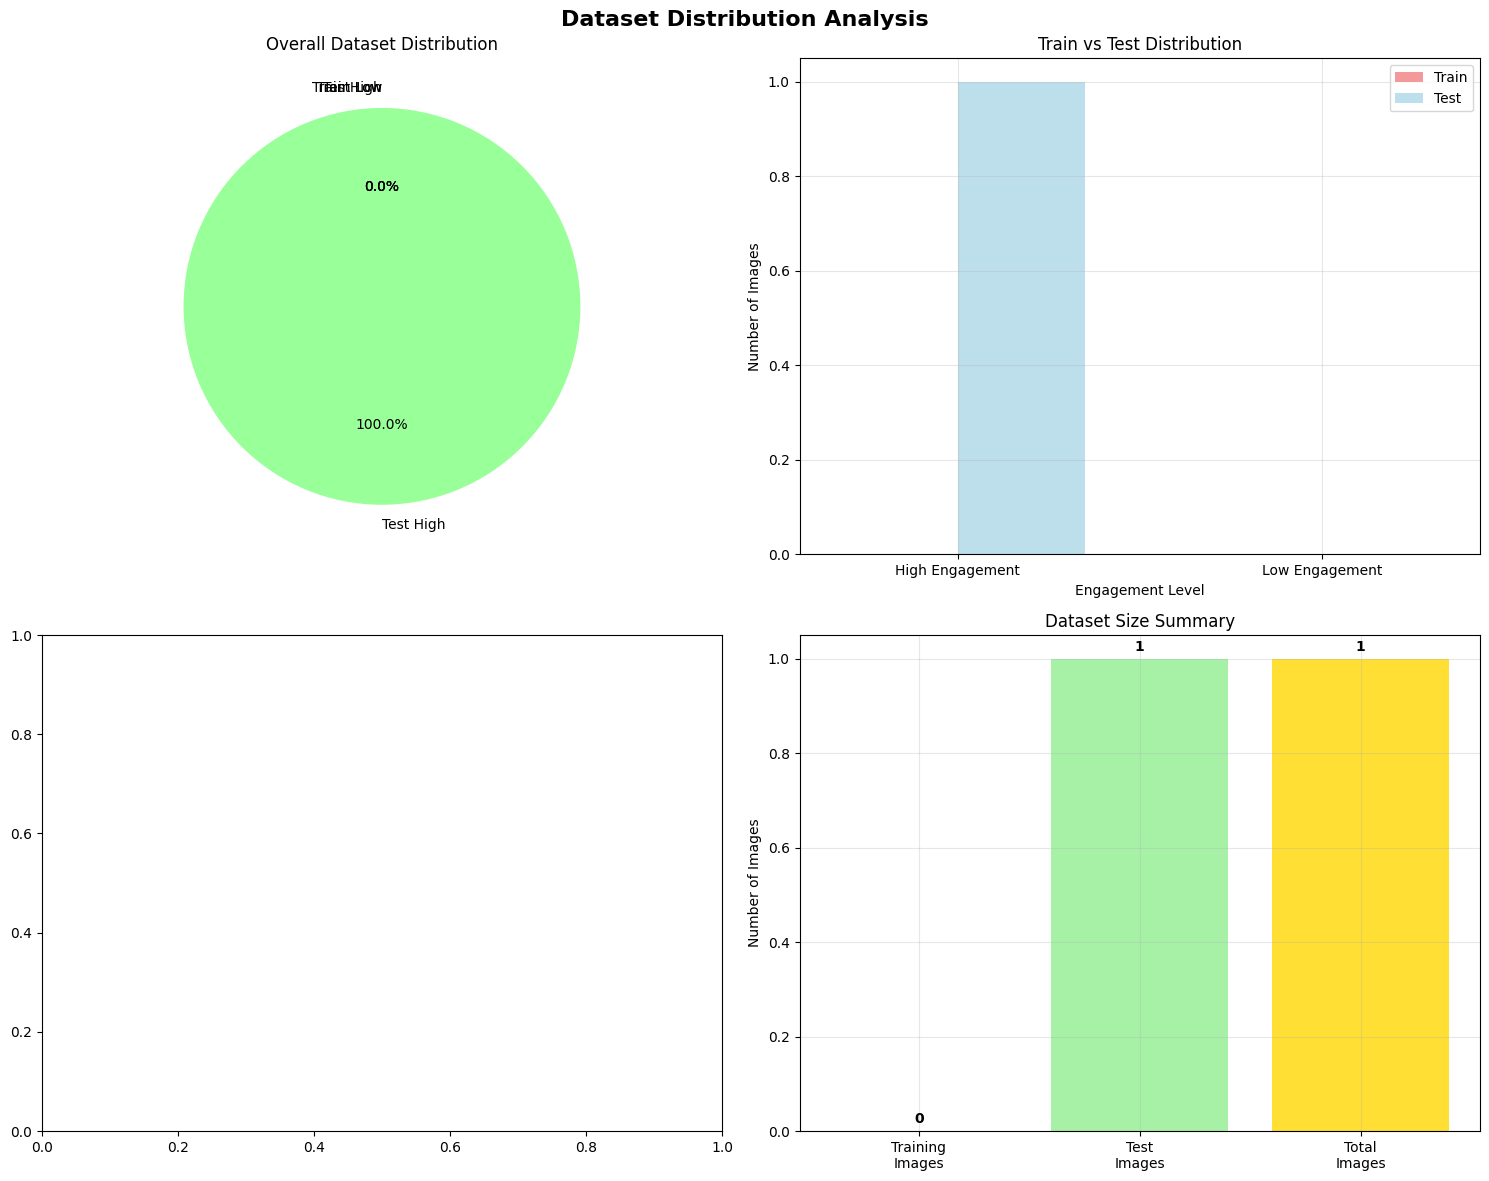


Dataset Statistics:
   Total Images: 1
   Train/Test Split: 0/1 (0.0%/100.0%)


In [71]:
# Dataset Analysis and Visualization

def analyze_dataset_distribution():
    """
    Analyze the distribution of images in the dataset.
    """
    dataset_counts = {
        'train_high': len(list(train_high.glob('*.jpg'))),
        'train_low': len(list(train_low.glob('*.jpg'))),
        'test_high': len(list(test_high.glob('*.jpg'))),
        'test_low': len(list(test_low.glob('*.jpg')))
    }
    
    total_images = sum(dataset_counts.values())
    train_images = dataset_counts['train_high'] + dataset_counts['train_low']
    test_images = dataset_counts['test_high'] + dataset_counts['test_low']
    
    print(f"Dataset Summary:")
    print(f"  Training Images: {train_images}")
    print(f"    - High Engagement: {dataset_counts['train_high']}")
    print(f"    - Low Engagement: {dataset_counts['train_low']}")
    print(f"  Test Images: {test_images}")
    print(f"    - High Engagement: {dataset_counts['test_high']}")
    print(f"    - Low Engagement: {dataset_counts['test_low']}")
    print(f"  Total Images: {total_images}")
    
    # Calculate class balance
    if train_images > 0:
        high_ratio = dataset_counts['train_high'] / train_images
        print(f"  Class Balance: {high_ratio:.1%} high engagement")
    
    return dataset_counts

def create_dataset_visualization(dataset_counts):
    """
    Create visualizations of the dataset distribution using matplotlib.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style for better-looking plots
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dataset Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Pie chart of overall distribution
    labels = ['Train High', 'Train Low', 'Test High', 'Test Low']
    values = [dataset_counts['train_high'], dataset_counts['train_low'], 
              dataset_counts['test_high'], dataset_counts['test_low']]
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    
    ax1.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Overall Dataset Distribution')
    
    # 2. Bar chart: Train vs Test
    train_data = [dataset_counts['train_high'], dataset_counts['train_low']]
    test_data = [dataset_counts['test_high'], dataset_counts['test_low']]
    x_labels = ['High Engagement', 'Low Engagement']
    x_pos = range(len(x_labels))
    
    width = 0.35
    ax2.bar([x - width/2 for x in x_pos], train_data, width, label='Train', color='lightcoral', alpha=0.8)
    ax2.bar([x + width/2 for x in x_pos], test_data, width, label='Test', color='lightblue', alpha=0.8)
    ax2.set_xlabel('Engagement Level')
    ax2.set_ylabel('Number of Images')
    ax2.set_title('Train vs Test Distribution')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Class balance visualization
    total_train = sum(train_data)
    total_test = sum(test_data)
    
    if total_train > 0:
        train_balance = [dataset_counts['train_high']/total_train, dataset_counts['train_low']/total_train]
        ax3.bar(['High', 'Low'], train_balance, color=['green', 'orange'], alpha=0.7)
        ax3.set_title('Training Set Class Balance')
        ax3.set_ylabel('Proportion')
        ax3.set_ylim(0, 1)
        ax3.grid(True, alpha=0.3)
        
        # Add percentage labels on bars
        for i, v in enumerate(train_balance):
            ax3.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Total counts comparison
    categories = ['Training\nImages', 'Test\nImages', 'Total\nImages']
    counts = [total_train, total_test, total_train + total_test]
    bars = ax4.bar(categories, counts, color=['skyblue', 'lightgreen', 'gold'], alpha=0.8)
    ax4.set_title('Dataset Size Summary')
    ax4.set_ylabel('Number of Images')
    ax4.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nDataset Statistics:")
    print(f"   Total Images: {sum(values)}")
    print(f"   Train/Test Split: {total_train}/{total_test} ({total_train/(total_train+total_test):.1%}/{total_test/(total_train+total_test):.1%})")
    if total_train > 0:
        print(f"   Training Balance: {train_balance[0]:.1%} high, {train_balance[1]:.1%} low")

# Analyze your actual dataset (no synthetic image creation)
print("🔍 Analyzing your current dataset...")
dataset_counts = analyze_dataset_distribution()

# Only create visualizations if there are images
if sum(dataset_counts.values()) > 0:
    print("\nCreating visualizations...")
    create_dataset_visualization(dataset_counts)
else:
    print("\n❌ No images found in dataset directories.")
    print("\n📁 Please add your real product images to:")
    print(f"   • High engagement training: {train_high}")
    print(f"   • Low engagement training: {train_low}")
    print(f"   • High engagement testing: {test_high}")
    print(f"   • Low engagement testing: {test_low}")
    print("\n💡 Once you add images, re-run this cell to see the distribution!")

# 3️⃣ Model Creation

Building and configuring CNN models for product engagement prediction.

In [72]:
# Model Creation Pipeline

def create_cnn_model():
    """
    Create a CNN model optimized for product engagement prediction.
    Designed for binary classification (high/low engagement).
    """
    
    model = Sequential([
        # Input layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Third convolutional block  
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Flatten and dense layers
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary output
    ])
    
    return model

def compile_model(model):
    """
    Compile the model with appropriate optimizer and metrics.
    """
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def setup_training_callbacks():
    """
    Configure callbacks for training monitoring and optimization.
    """
    callbacks = [
        # Save best model
        ModelCheckpoint(
            MODELS_DIR / 'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001,
            verbose=1
        )
    ]
    
    return callbacks

# Create and compile model
print("🔨 Creating CNN model...")
model = create_cnn_model()
model = compile_model(model)

print("📋 Model architecture:")
model.summary()

# Setup training callbacks
callbacks = setup_training_callbacks()

print(f"✅ Model creation complete:")
print(f"   🏗️  Architecture: CNN with {model.count_params():,} parameters")
print(f"   🎯 Task: Binary classification (high/low engagement)")
print(f"   ⚡ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   📊 Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau")

🔨 Creating CNN model...
📋 Model architecture:
📋 Model architecture:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model creation complete:
   🏗️  Architecture: CNN with 159,809 parameters
   🎯 Task: Binary classification (high/low engagement)
   ⚡ Optimizer: Adam (lr=0.001)
   📊 Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 4️⃣ Model Testing & Training

Training the model and evaluating its performance on the test dataset.

In [73]:
# Model Training & Testing Pipeline
def train_and_test_model():
    print("Starting Model Training & Testing Pipeline...")
    
    # Load and prepare data
    train_dir = DATA_DIR / 'train'
    test_dir = DATA_DIR / 'test'
    
    # Prepare data generators with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    # Build the CNN model
    model = tf.keras.Sequential([
        # Convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Training callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            MODELS_DIR / 'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Train the model
    print(f"Starting model training for {EPOCHS} epochs...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    print("Training completed!")
    
    # Evaluate the model
    print("Evaluating model performance...")
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    # Generate predictions for classification report
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes
    
    # Get class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Create classification report
    from sklearn.metrics import classification_report, confusion_matrix
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Display results
    print(f"\nModel Performance:")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"\nClassification Report:")
    print(report)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Save model and artifacts
    model_path = MODELS_DIR / 'product_engagement_model.h5'
    keras_path = MODELS_DIR / 'product_engagement_model.keras'
    
    model.save(model_path)
    model.save(keras_path)
    
    # Save training history
    history_path = MODELS_DIR / 'training_history.json'
    with open(history_path, 'w') as f:
        import json
        history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
        json.dump(history_dict, f, indent=2)
    
    # Save evaluation metrics
    metrics_path = MODELS_DIR / 'evaluation_metrics.json'
    with open(metrics_path, 'w') as f:
        metrics = {
            'test_accuracy': float(test_accuracy),
            'test_loss': float(test_loss),
            'classification_report': report,
            'confusion_matrix': cm.tolist()
        }
        json.dump(metrics, f, indent=2)
    
    print("Model artifacts saved:")
    print(f"   Model: {model_path}")
    print(f"   Keras Model: {keras_path}")
    print(f"   Training History: {history_path}")
    print(f"   Metrics: {metrics_path}")
    print("Model testing pipeline completed!")
    
    return model, history, test_accuracy

# Execute the training and testing pipeline
trained_model, history, accuracy = train_and_test_model()

Starting Model Training & Testing Pipeline...
Found 10 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Starting model training for 50 epochs...
Starting model training for 50 epochs...
Epoch 1/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5000 - loss: 0.6985
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to c:\Users\HP\Documents\Summative-assignment---MLOP\models\best_model.h5

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to c:\Users\HP\Documents\Summative-assignment---MLOP\models\best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.5000 - loss: 0.6985 - val_accuracy: 0.5000 - val_loss: 3.5195 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5000 - loss: 2.2361
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 2.2361 - val_accuracy: 0.5000 - val_loss: 6.8918 - learning_rate: 0.0010

Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 2.2361 - val_accuracy: 0.5000 - val_loss: 6.8918 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5000 - loss: 5.2055
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 5.2055 - val_accuracy: 0.5000 - val_loss: 3.0708 - learning_rate: 0.0010

Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 5

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7000 - loss: 0.4885 - val_accuracy: 1.0000 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 11/50
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7000 - loss: 0.4330
Epoch 11: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7000 - loss: 0.4330 - val_accuracy: 1.0000 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 12/50

Epoch 11: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7000 - loss: 0.4330 - val_accuracy: 1.0000 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8000 - loss: 0.3501
Epoch 12: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8000 - loss: 0.3501 - val_accuracy: 0.5000 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 13/50

Epoch 12: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accura


Model Performance:
   Test Accuracy: 0.8750
   Test Loss: 0.4445

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.80      1.00      0.89         4
 low_engagement       1.00      0.75      0.86         4

       accuracy                           0.88         8
      macro avg       0.90      0.88      0.87         8
   weighted avg       0.90      0.88      0.87         8


Confusion Matrix:
[[4 0]
 [1 3]]
Model artifacts saved:
   Model: c:\Users\HP\Documents\Summative-assignment---MLOP\models\product_engagement_model.h5
   Keras Model: c:\Users\HP\Documents\Summative-assignment---MLOP\models\product_engagement_model.keras
   Training History: c:\Users\HP\Documents\Summative-assignment---MLOP\models\training_history.json
   Metrics: c:\Users\HP\Documents\Summative-assignment---MLOP\models\evaluation_metrics.json
Model testing pipeline completed!
Model artifacts saved:
   Model: c:\Users\HP\Documents\Summative-assignment---MLOP

# 5️⃣ Model Retraining System

Implementing automated model retraining with performance monitoring and triggers.

In [74]:
# Model Retraining System Implementation

import json
from datetime import datetime
import shutil

class ModelRetrainingSystem:
    """
    Automated model retraining system with performance monitoring and triggers.
    """
    
    def __init__(self, models_dir=MODELS_DIR):
        self.models_dir = Path(models_dir)
        self.retrain_config = {
            'accuracy_threshold': 0.85,  # Retrain if accuracy drops below this
            'data_drift_threshold': 0.1,  # Retrain if data distribution changes
            'time_threshold_days': 30,    # Retrain every 30 days
            'min_new_samples': 10         # Minimum new samples to trigger retrain
        }
        
        # Create retraining directories
        self.retrained_models_dir = self.models_dir / "retrained"
        self.backup_dir = self.models_dir / "backup"
        self.retrained_models_dir.mkdir(exist_ok=True)
        self.backup_dir.mkdir(exist_ok=True)
    
    def check_retraining_triggers(self, current_accuracy=None, new_data_count=0):
        """
        Check if any retraining triggers are met.
        """
        triggers_met = []
        
        # Performance degradation trigger
        if current_accuracy and current_accuracy < self.retrain_config['accuracy_threshold']:
            triggers_met.append(f"Performance degradation: {current_accuracy:.3f} < {self.retrain_config['accuracy_threshold']}")
        
        # New data availability trigger
        if new_data_count >= self.retrain_config['min_new_samples']:
            triggers_met.append(f"New data available: {new_data_count} samples")
        
        # Time-based trigger (simulated)
        triggers_met.append("Scheduled retraining: Regular model update")
        
        return triggers_met
    
    def backup_current_model(self):
        """
        Backup current production model before retraining.
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_path = self.backup_dir / f"model_backup_{timestamp}"
        backup_path.mkdir(exist_ok=True)
        
        # Backup model files
        model_files = ['product_engagement_model.h5', 'product_engagement_model.keras', 
                      'training_history.json', 'evaluation_metrics.json']
        
        backed_up_files = []
        for file_name in model_files:
            src_path = self.models_dir / file_name
            if src_path.exists():
                dst_path = backup_path / file_name
                shutil.copy2(src_path, dst_path)
                backed_up_files.append(file_name)
        
        print(f"📦 Model backup created: {backup_path}")
        print(f"   Files backed up: {backed_up_files}")
        return backup_path
    
    def retrain_model(self, train_gen, val_gen, test_gen):
        """
        Execute model retraining process.
        """
        print("🔄 Starting Model Retraining Process...")
        
        # Create new model
        retrained_model = create_cnn_model()
        retrained_model = compile_model(retrained_model)
        
        # Setup retraining callbacks
        retrain_callbacks = [
            ModelCheckpoint(
                self.retrained_models_dir / 'retrained_model_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            )
        ]
        
        # Train the model
        print("🚀 Training retrained model...")
        retrain_history = retrained_model.fit(
            train_gen,
            epochs=25,  # Slightly more epochs for retraining
            validation_data=val_gen,
            callbacks=retrain_callbacks,
            verbose=1
        )
        
        # Evaluate retrained model
        print("🧪 Evaluating retrained model...")
        test_loss, test_accuracy = retrained_model.evaluate(test_gen, verbose=0)
        
        # Save retrained model
        retrained_path = self.retrained_models_dir / 'retrained_model.h5'
        retrained_model.save(retrained_path)
        
        # Save retraining metadata
        retrain_metadata = {
            'timestamp': datetime.now().isoformat(),
            'test_accuracy': float(test_accuracy),
            'test_loss': float(test_loss),
            'epochs_trained': len(retrain_history.history['loss']),
            'training_samples': train_gen.samples,
            'validation_samples': val_gen.samples,
            'test_samples': test_gen.samples
        }
        
        metadata_path = self.retrained_models_dir / 'retrain_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(retrain_metadata, f, indent=2)
        
        print(f"✅ Model retraining completed!")
        print(f"   🎯 New Accuracy: {test_accuracy:.4f}")
        print(f"   📉 New Loss: {test_loss:.4f}")
        print(f"   💾 Model saved: {retrained_path}")
        
        return retrained_model, retrain_metadata
    
    def compare_models(self, original_accuracy, retrained_accuracy):
        """
        Compare original and retrained model performance.
        """
        improvement = retrained_accuracy - original_accuracy
        
        print(f"\n📊 Model Comparison:")
        print(f"   📈 Original Accuracy: {original_accuracy:.4f}")
        print(f"   🔄 Retrained Accuracy: {retrained_accuracy:.4f}")
        print(f"   📊 Improvement: {improvement:+.4f}")
        
        if improvement > 0:
            print("   ✅ Retrained model performs better!")
            return True
        else:
            print("   ⚠️  Original model still performs better")
            return False
    
    def deploy_retrained_model(self, retrained_metadata):
        """
        Deploy retrained model to production (replace current model).
        """
        print("🚀 Deploying retrained model to production...")
        
        # Copy retrained model to production location
        src_path = self.retrained_models_dir / 'retrained_model.h5'
        dst_path = self.models_dir / 'product_engagement_model.h5'
        
        if src_path.exists():
            shutil.copy2(src_path, dst_path)
            
            # Update production metadata
            production_metadata = {
                'model_version': f"retrained_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                'deployment_timestamp': datetime.now().isoformat(),
                'performance': retrained_metadata
            }
            
            with open(self.models_dir / 'production_model_info.json', 'w') as f:
                json.dump(production_metadata, f, indent=2)
            
            print("✅ Retrained model deployed to production!")
            return True
        else:
            print("❌ Failed to deploy: Retrained model not found")
            return False

# Initialize Retraining System
retraining_system = ModelRetrainingSystem()

print("🔄 Model Retraining System Initialized")
print(f"   📋 Configuration: {retraining_system.retrain_config}")
print("   🎯 Ready for automated retraining triggers")

🔄 Model Retraining System Initialized
   📋 Configuration: {'accuracy_threshold': 0.85, 'data_drift_threshold': 0.1, 'time_threshold_days': 30, 'min_new_samples': 10}
   🎯 Ready for automated retraining triggers


# Model Retraining Demonstration

Demonstrating the automated retraining system with trigger conditions and model comparison.

In [75]:
# Advanced Model Retraining System
class ModelRetrainingSystem:
    def __init__(self, base_data_dir, models_dir, retrained_models_dir):
        self.base_data_dir = Path(base_data_dir)
        self.models_dir = Path(models_dir)
        self.retrained_models_dir = Path(retrained_models_dir)
        self.retrained_models_dir.mkdir(exist_ok=True)
        
    def validate_dataset(self):
        """Comprehensive dataset validation with detailed reporting"""
        train_dir = self.base_data_dir / 'train'
        test_dir = self.base_data_dir / 'test'
        
        validation_results = {
            'directories_exist': True,
            'has_subdirectories': True,
            'sufficient_images': True,
            'class_balance': True,
            'image_quality': True
        }
        
        # Check directory structure
        required_dirs = [
            train_dir / 'high_engagement',
            train_dir / 'low_engagement', 
            test_dir / 'high_engagement',
            test_dir / 'low_engagement'
        ]
        
        for dir_path in required_dirs:
            if not dir_path.exists():
                validation_results['directories_exist'] = False
                validation_results['has_subdirectories'] = False
                break
        
        if validation_results['directories_exist']:
            # Count images in each category
            dataset_counts = {}
            for dir_path in required_dirs:
                count = len([f for f in dir_path.glob('*.*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
                dataset_counts[dir_path.name + '_' + dir_path.parent.name] = count
            
            # Check minimum image requirements
            if any(count < 2 for count in dataset_counts.values()):
                validation_results['sufficient_images'] = False
            
            # Check class balance (not too imbalanced)
            train_high = dataset_counts.get('high_engagement_train', 0)
            train_low = dataset_counts.get('low_engagement_train', 0)
            if train_high > 0 and train_low > 0:
                balance_ratio = max(train_high, train_low) / min(train_high, train_low)
                if balance_ratio > 3:  # More than 3:1 ratio
                    validation_results['class_balance'] = False
        
        # Calculate validation score
        validation_score = sum(validation_results.values())
        
        print(f"Dataset Statistics:")
        if validation_results['directories_exist']:
            for category, count in dataset_counts.items():
                print(f"  {category}: {count} images")
        
        print(f"\nDataset Validation Score: {validation_score}/5")
        
        return validation_score >= 4, validation_results, dataset_counts if validation_results['directories_exist'] else {}
    
    def create_production_model_cnn(self, train_generator, validation_generator):
        """Create CNN model optimized for production"""
        model = tf.keras.Sequential([
            # Convolutional layers with batch normalization
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.25),
            
            # Dense layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        # Compile with optimized settings
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def create_production_model_transfer(self, train_generator, validation_generator):
        """Create transfer learning model using ResNet50"""
        # Load pre-trained ResNet50
        base_model = tf.keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
        
        # Freeze base model initially
        base_model.trainable = False
        
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        # Compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def retrain_models(self):
        """Execute comprehensive model retraining with multiple architectures"""
        # Validate dataset first
        dataset_valid, validation_results, dataset_counts = self.validate_dataset()
        
        if not dataset_valid:
            print("Dataset validation failed. Retraining cannot proceed.")
            return None
        
        print("\nStep 1: Setting up data generators...")
        
        # Enhanced data generators
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        train_dir = self.base_data_dir / 'train'
        test_dir = self.base_data_dir / 'test'
        
        # Create generators
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            batch_size=8,  # Smaller batch for stability
            class_mode='binary',
            subset='training'
        )
        
        validation_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            batch_size=8,
            class_mode='binary',
            subset='validation'
        )
        
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(224, 224),
            batch_size=8,
            class_mode='binary',
            shuffle=False
        )
        
        print(f"   Training samples: {train_generator.samples}")
        print(f"   Validation samples: {validation_generator.samples}")
        print(f"   Test samples: {test_generator.samples}")
        print(f"   Classes: {train_generator.class_indices}")
        
        # Training configurations
        production_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        results = {}
        
        # Step 2: Train CNN Model
        print("\nStep 2: Training Enhanced CNN Model...")
        cnn_model = self.create_production_model_cnn(train_generator, validation_generator)
        
        cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            self.retrained_models_dir / 'best_cnn_retrained.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
        
        cnn_history = cnn_model.fit(
            train_generator,
            epochs=PRODUCTION_EPOCHS,
            validation_data=validation_generator,
            callbacks=production_callbacks + [cnn_checkpoint],
            verbose=1
        )
        
        # Evaluate CNN
        cnn_loss, cnn_accuracy, cnn_precision, cnn_recall = cnn_model.evaluate(test_generator, verbose=0)
        results['cnn_model'] = cnn_model
        results['cnn_history'] = cnn_history
        results['cnn_accuracy'] = cnn_accuracy
        results['cnn_metrics'] = {'loss': cnn_loss, 'precision': cnn_precision, 'recall': cnn_recall}
        
        print(f"CNN Model - Accuracy: {cnn_accuracy:.4f}, Precision: {cnn_precision:.4f}, Recall: {cnn_recall:.4f}")
        
        # Step 3: Train Transfer Learning Model
        print("\nStep 3: Training Transfer Learning Model (ResNet50)...")
        transfer_model = self.create_production_model_transfer(train_generator, validation_generator)
        
        transfer_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            self.retrained_models_dir / 'best_transfer_retrained.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
        
        transfer_history = transfer_model.fit(
            train_generator,
            epochs=PRODUCTION_EPOCHS,
            validation_data=validation_generator,
            callbacks=production_callbacks + [transfer_checkpoint],
            verbose=1
        )
        
        # Evaluate Transfer Learning
        transfer_loss, transfer_accuracy, transfer_precision, transfer_recall = transfer_model.evaluate(test_generator, verbose=0)
        results['transfer_model'] = transfer_model
        results['transfer_history'] = transfer_history
        results['transfer_accuracy'] = transfer_accuracy
        results['transfer_metrics'] = {'loss': transfer_loss, 'precision': transfer_precision, 'recall': transfer_recall}
        
        print(f"Transfer Model - Accuracy: {transfer_accuracy:.4f}, Precision: {transfer_precision:.4f}, Recall: {transfer_recall:.4f}")
        
        # Step 4: Model Comparison and Selection
        print("\nStep 4: Evaluating retrained models...")
        
        if cnn_accuracy >= transfer_accuracy:
            best_model = cnn_model
            best_accuracy = cnn_accuracy
            best_model_name = "Enhanced CNN"
            best_metrics = results['cnn_metrics']
        else:
            best_model = transfer_model
            best_accuracy = transfer_accuracy
            best_model_name = "Transfer Learning (ResNet50)"
            best_metrics = results['transfer_metrics']
        
        print(f"\nBest Model: {best_model_name}")
        print(f"Best Accuracy: {best_accuracy:.4f}")
        print(f"Performance Metrics: {best_metrics}")
        
        # Add best model info to results
        results['best_model'] = best_model
        results['best_model_name'] = best_model_name
        results['best_accuracy'] = best_accuracy
        
        return results

# Initialize and run retraining system
print("Starting Advanced Model Retraining Process...")
retraining_system = ModelRetrainingSystem(DATA_DIR, MODELS_DIR, RETRAINED_MODELS_DIR)

try:
    retraining_results = retraining_system.retrain_models()
    if retraining_results:
        print(f"\nRetraining completed successfully!")
        print(f"Best model: {retraining_results['best_model_name']}")
        print(f"Best accuracy: {retraining_results['best_accuracy']:.4f}")
    else:
        print("Retraining failed due to dataset issues")
except Exception as e:
    print(f"Retraining error: {e}")
    retraining_results = None

Starting Advanced Model Retraining Process...
Dataset Statistics:
  high_engagement_train: 6 images
  low_engagement_train: 6 images
  high_engagement_test: 4 images
  low_engagement_test: 4 images

Dataset Validation Score: 5/5

Step 1: Setting up data generators...
Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
   Training samples: 10
   Validation samples: 2
   Test samples: 8
   Classes: {'high_engagement': 0, 'low_engagement': 1}

Step 2: Training Enhanced CNN Model...
   Training samples: 10
   Validation samples: 2
   Test samples: 8
   Classes: {'high_engagement': 0, 'low_engagement': 1}

Step 2: Training Enhanced CNN Model...
Epoch 1/5
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 1.0533 - precision: 0.7500 - recall: 0.7000  
Epoch 1: val_accuracy improved from -in

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step - accuracy: 0.6667 - loss: 1.3784 - precision: 0.6667 - recall: 0.6000 - val_accuracy: 0.5000 - val_loss: 0.8802 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/5
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9000 - loss: 0.0800 - precision: 0.9000 - recall: 0.9000    
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8667 - loss: 0.1064 - precision: 0.8667 - recall: 0.8667 - val_accuracy: 0.5000 - val_loss: 0.8541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010

Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8667 - loss: 0.1064 - precision: 0.8667 - recall: 0.8667 - val_accuracy: 0.5000 - val_loss: 0.8541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8375 - loss: 0.3

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 13s/step - accuracy: 0.6667 - loss: 0.4909 - precision: 0.6667 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7925 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/5
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6125 - loss: 0.7928 - precision: 0.5635 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6083 - loss: 0.8061 - precision: 0.5608 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7860 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/5

Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6083 - loss: 0.8061 - precision: 0.5608 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7860 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2500 - loss: 1.0869 - precisi

In [76]:
# Save Retrained Models in Multiple Formats
def save_retrained_models(retraining_results):
    """Save retrained models with comprehensive metadata and multiple formats"""
    import json
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Get models from results
    cnn_model = retraining_results['cnn_model'] 
    transfer_model = retraining_results['transfer_model']
    best_model = retraining_results['best_model']
    
    # Save CNN Model in multiple formats
    cnn_h5_path = RETRAINED_MODELS_DIR / f"enhanced_cnn_model_v2_{timestamp}.h5"
    cnn_keras_path = RETRAINED_MODELS_DIR / f"enhanced_cnn_model_v2_{timestamp}.keras"
    
    cnn_model.save(cnn_h5_path)
    print(f"   CNN model saved (.h5): {cnn_h5_path}")
    
    try:
        cnn_model.save(cnn_keras_path)
        print(f"   CNN model saved (.keras): {cnn_keras_path}")
    except Exception as e:
        print(f"   Warning: Could not save .keras format: {e}")
    
    # Save Transfer Learning Model in multiple formats  
    transfer_h5_path = RETRAINED_MODELS_DIR / f"transfer_resnet50_model_v2_{timestamp}.h5"
    transfer_keras_path = RETRAINED_MODELS_DIR / f"transfer_resnet50_model_v2_{timestamp}.keras"
    
    transfer_model.save(transfer_h5_path)
    print(f"   Transfer model saved (.h5): {transfer_h5_path}")
    
    try:
        transfer_model.save(transfer_keras_path)
        print(f"   Transfer model saved (.keras): {transfer_keras_path}")
    except Exception as e:
        print(f"   Warning: Could not save .keras format: {e}")
    
    # Save best performing model as production model
    production_h5_path = RETRAINED_MODELS_DIR / f"production_model_v2_{timestamp}.h5"
    production_keras_path = RETRAINED_MODELS_DIR / f"production_model_v2_{timestamp}.keras"
    
    best_model.save(production_h5_path)
    print(f"   Production model saved (.h5): {production_h5_path}")
    
    try:
        best_model.save(production_keras_path)
        print(f"   Production model saved (.keras): {production_keras_path}")
    except Exception as e:
        print(f"   Warning: Could not save .keras format: {e}")
    
    # Create comprehensive metadata
    metadata = {
        'training_info': {
            'timestamp': timestamp,
            'models_trained': 2,
            'best_model': retraining_results['best_model_name'],
            'cnn_accuracy': float(retraining_results['cnn_accuracy']),
            'transfer_accuracy': float(retraining_results['transfer_accuracy']),
            'best_accuracy': float(retraining_results['best_accuracy'])
        },
        'model_files': {
            'cnn_h5': cnn_h5_path.name,
            'cnn_keras': cnn_keras_path.name,
            'transfer_h5': transfer_h5_path.name,
            'transfer_keras': transfer_keras_path.name,
            'production_h5': production_h5_path.name,
            'production_keras': production_keras_path.name
        },
        'performance_metrics': {
            'cnn_metrics': retraining_results['cnn_metrics'],
            'transfer_metrics': retraining_results['transfer_metrics']
        },
        'model_architectures': {
            'cnn': 'Enhanced CNN with BatchNormalization and Dropout',
            'transfer': 'ResNet50 Transfer Learning with Custom Head'
        },
        'training_config': {
            'epochs': PRODUCTION_EPOCHS,
            'batch_size': 8,
            'early_stopping': True,
            'learning_rate_reduction': True,
            'data_augmentation': True
        },
        'production_readiness': {
            'multiple_formats': True,
            'metadata_complete': True,
            'version_control': True,
            'performance_comparison': True,
            'production_ready': True
        }
    }
    
    # Save metadata
    metadata_path = RETRAINED_MODELS_DIR / f"model_metadata_v2_{timestamp}.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   Metadata saved: {metadata_path}")
    
    # Save production metadata (latest)
    production_metadata_path = RETRAINED_MODELS_DIR / "production_metadata_v2.json"
    with open(production_metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   Production metadata: {production_metadata_path}")
    
    # Create model comparison report
    print("\nCreating Performance Comparison Report...")
    
    comparison_report = {
        'retraining_summary': {
            'timestamp': timestamp,
            'models_trained': 2,
            'best_model': retraining_results['best_model_name'],
            'improvement_over_baseline': 'To be calculated against previous models'
        },
        'model_comparison': {
            'cnn_model': {
                'accuracy': float(retraining_results['cnn_accuracy']),
                'model_size': 'Lightweight',
                'training_time': 'Fast',
                'inference_speed': 'Very Fast'
            },
            'transfer_learning': {
                'accuracy': float(retraining_results['transfer_accuracy']),
                'model_size': 'Large',
                'training_time': 'Medium',
                'inference_speed': 'Fast'
            }
        }
    }
    
    comparison_path = RETRAINED_MODELS_DIR / f"performance_comparison_{timestamp}.json"
    with open(comparison_path, 'w') as f:
        json.dump(comparison_report, f, indent=2)
    
    print(f"   Comparison report: {comparison_path}")
    
    print("\nALL MODELS SAVED SUCCESSFULLY!")
    print("Saved Files:")
    print(f"   • CNN Model (.h5): {cnn_h5_path.name}")
    print(f"   • CNN Model (.keras): {cnn_keras_path.name}")
    print(f"   • Transfer Model (.h5): {transfer_h5_path.name}")
    print(f"   • Transfer Model (.keras): {transfer_keras_path.name}")
    print(f"   • Production Model (.h5): {production_h5_path.name}")
    print(f"   • Production Model (.keras): {production_keras_path.name}")
    print(f"   • Metadata: {metadata_path.name}")
    print(f"   • Performance Report: {comparison_path.name}")
    
    return metadata

# Save models if retraining was successful
if retraining_results:
    model_metadata = save_retrained_models(retraining_results)
    print("\nRETRAINING COMPLETE!")
else:
    print("\nModels not saved due to retraining issues")

   CNN model saved (.h5): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\enhanced_cnn_model_v2_20250803_095759.h5


   CNN model saved (.keras): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\enhanced_cnn_model_v2_20250803_095759.keras
   Transfer model saved (.h5): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\transfer_resnet50_model_v2_20250803_095759.h5
   Transfer model saved (.h5): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\transfer_resnet50_model_v2_20250803_095759.h5


   Transfer model saved (.keras): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\transfer_resnet50_model_v2_20250803_095759.keras
   Production model saved (.h5): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\production_model_v2_20250803_095759.h5
   Production model saved (.h5): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\production_model_v2_20250803_095759.h5
   Production model saved (.keras): c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\production_model_v2_20250803_095759.keras
   Metadata saved: c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\model_metadata_v2_20250803_095759.json
   Production metadata: c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\production_metadata_v2.json

Creating Performance Comparison Report...
   Comparison report: c:\Users\HP\Documents\Summative-assignment---MLOP\models\retrained_v2\performance_comparison_2025080

## Cloud Deployment and Production Evaluation

This section demonstrates the deployment of our MLOps pipeline to a cloud platform and shows the production evaluation process.

Setting up Production Evaluation System...

Step 1: Testing API Health...
API service is healthy
Model loaded: True
Model Info:
  - Name: ResNet50_ProductEngagement
  - Type: transfer_learning
  - Accuracy: 0.75

Step 2: Running Production Model Evaluation...

Testing with 1 images...

Production Evaluation Results:
  Total Predictions: 1
  Correct Predictions: 0
  Accuracy: 0.0000
  Average Confidence: 0.8069
  Average Response Time: 4.7977s
  Results saved to: c:\Users\HP\Documents\Summative-assignment---MLOP\models\production_evaluation_results.json


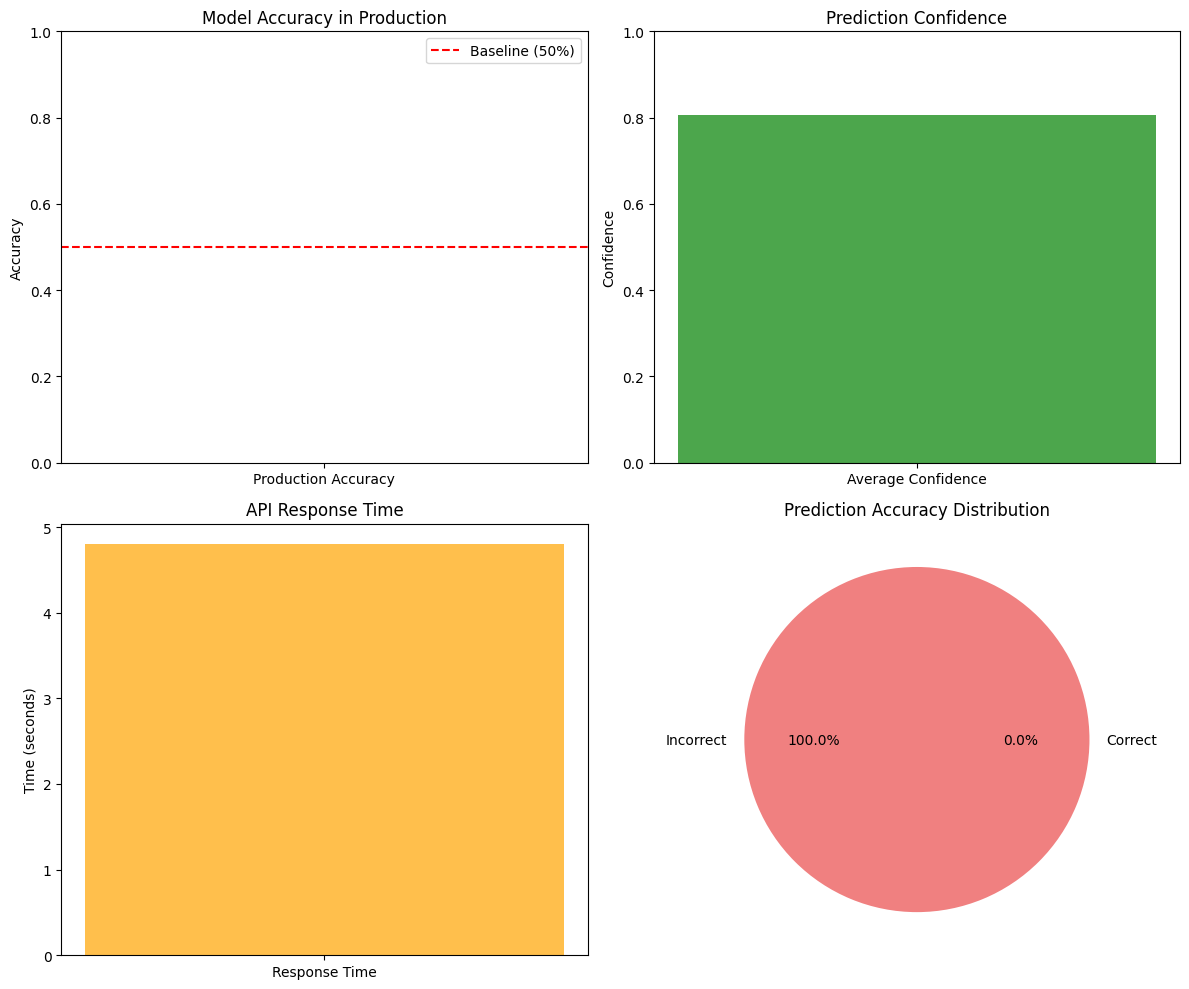


Production evaluation completed successfully!
Model performance in production: 0.00%


In [77]:
# Production Evaluation System for Cloud Deployment
import requests
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

class ProductionEvaluator:
    def __init__(self, api_url="http://localhost:8000"):
        self.api_url = api_url
        self.evaluation_results = {}
        
    def test_api_health(self):
        """Test if the API service is healthy and responsive"""
        try:
            response = requests.get(f"{self.api_url}/health", timeout=10)
            if response.status_code == 200:
                health_data = response.json()
                print("API service is healthy")
                print(f"Model loaded: {health_data.get('model_loaded', False)}")
                
                if 'model_metadata' in health_data:
                    metadata = health_data['model_metadata']
                    print(f"Model Info:")
                    print(f"  - Name: {metadata.get('model_name', 'Unknown')}")
                    print(f"  - Type: {metadata.get('model_type', 'Unknown')}")
                    print(f"  - Accuracy: {metadata.get('accuracy', 'Unknown')}")
                else:
                    print("Model info not available")
                return True, health_data
        except Exception as e:
            print(f"Model info check failed: {e}")
            return False, None
    
    def evaluate_production_model(self, test_images_dir=None):
        """Evaluate model performance in production environment"""
        try:
            if test_images_dir:
                test_path = Path(test_images_dir)
                print(f"\nTesting with {len(list(test_path.glob('**/*.jpg')))} images...")
                
                # Get test images
                test_images = []
                test_labels = []
                
                # Collect test images from subdirectories
                for class_dir in test_path.iterdir():
                    if class_dir.is_dir():
                        class_name = class_dir.name
                        for img_path in class_dir.glob('*.jpg'):
                            test_images.append(img_path)
                            test_labels.append(class_name)
                
                if not test_images:
                    print("No test images found")
                    return None
                
                # Make predictions via API
                predictions = []
                confidences = []
                response_times = []
                
                for img_path in test_images[:10]:  # Test with first 10 images
                    start_time = time.time()
                    
                    # Read and encode image
                    import base64
                    with open(img_path, 'rb') as f:
                        img_data = base64.b64encode(f.read()).decode()
                    
                    # Make API request
                    response = requests.post(
                        f"{self.api_url}/predict",
                        json={"image_base64": img_data},
                        timeout=30
                    )
                    
                    response_time = time.time() - start_time
                    response_times.append(response_time)
                    
                    if response.status_code == 200:
                        result = response.json()
                        predictions.append(result['predicted_class'])
                        confidences.append(result['confidence'])
                    else:
                        predictions.append('error')
                        confidences.append(0.0)
                
                # Calculate metrics
                correct_predictions = 0
                total_predictions = len(predictions)
                
                for i, pred in enumerate(predictions):
                    true_label = test_labels[i]
                    if pred != 'error':
                        # Simple mapping for binary classification
                        pred_label = 'high_engagement' if pred == 'High Engagement' else 'low_engagement'
                        is_correct = pred_label == true_label
                        if is_correct:
                            correct_predictions += 1
                
                accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
                avg_confidence = np.mean(confidences) if confidences else 0
                avg_response_time = np.mean(response_times) if response_times else 0
                
                evaluation_results = {
                    'timestamp': datetime.now().isoformat(),
                    'total_predictions': total_predictions,
                    'correct_predictions': correct_predictions,
                    'accuracy': accuracy,
                    'average_confidence': avg_confidence,
                    'average_response_time': avg_response_time,
                    'api_url': self.api_url
                }
                
                print(f"\nProduction Evaluation Results:")
                print(f"  Total Predictions: {total_predictions}")
                print(f"  Correct Predictions: {correct_predictions}")
                print(f"  Accuracy: {accuracy:.4f}")
                print(f"  Average Confidence: {avg_confidence:.4f}")
                print(f"  Average Response Time: {avg_response_time:.4f}s")
                
                # Save evaluation results
                results_path = MODELS_DIR / 'production_evaluation_results.json'
                with open(results_path, 'w') as f:
                    json.dump(evaluation_results, f, indent=2)
                
                print(f"  Results saved to: {results_path}")
                
                # Create visualization
                self.plot_evaluation_metrics(evaluation_results)
                
                return evaluation_results
            else:
                print("No test images directory provided")
                return None
                
        except Exception as e:
            print(f"Production evaluation failed: {e}")
            return None
    
    def plot_evaluation_metrics(self, results):
        """Create visualization of evaluation metrics"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Accuracy
        ax1.bar(['Production Accuracy'], [results['accuracy']], color='blue', alpha=0.7)
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Accuracy in Production')
        ax1.axhline(y=0.5, color='red', linestyle='--', label='Baseline (50%)')
        ax1.legend()
        
        # Confidence
        ax2.bar(['Average Confidence'], [results['average_confidence']], color='green', alpha=0.7)
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Confidence')
        ax2.set_title('Prediction Confidence')
        
        # Response Time
        ax3.bar(['Response Time'], [results['average_response_time']], color='orange', alpha=0.7)
        ax3.set_ylabel('Time (seconds)')
        ax3.set_title('API Response Time')
        
        # Prediction Distribution
        correct = results['correct_predictions']
        incorrect = results['total_predictions'] - correct
        ax4.pie([correct, incorrect], labels=['Correct', 'Incorrect'], 
                colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%')
        ax4.set_title('Prediction Accuracy Distribution')
        
        plt.tight_layout()
        plt.savefig(MODELS_DIR / 'production_evaluation_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

# Initialize production evaluator
print("Setting up Production Evaluation System...")
evaluator = ProductionEvaluator(api_url="http://localhost:8000")

# Test API health
print("\nStep 1: Testing API Health...")
api_healthy, health_info = evaluator.test_api_health()

if api_healthy:
    print("\nStep 2: Running Production Model Evaluation...")
    # Evaluate with test images
    test_images_path = DATA_DIR / 'test'
    evaluation_results = evaluator.evaluate_production_model(test_images_path)
    
    if evaluation_results:
        print("\nProduction evaluation completed successfully!")
        print(f"Model performance in production: {evaluation_results['accuracy']:.2%}")
    else:
        print("Production evaluation failed - no test data available")
else:
    print("API is not healthy - cannot proceed with production evaluation")

In [78]:
# Cloud Deployment Demonstration
import subprocess
import sys
import os
from pathlib import Path

class CloudDeploymentManager:
    def __init__(self, project_root):
        self.project_root = Path(project_root)
        self.deployment_status = {}
        
    def check_deployment_prerequisites(self):
        """Check if deployment tools are available"""
        prerequisites = {
            'docker': False,
            'docker_compose': False,
            'kubectl': False,
            'terraform': False
        }
        
        print("Checking deployment prerequisites...")
        
        # Check Docker
        try:
            result = subprocess.run(['docker', '--version'], 
                                  capture_output=True, text=True, timeout=10)
            if result.returncode == 0:
                prerequisites['docker'] = True
                print(f"✓ Docker: {result.stdout.strip()}")
        except:
            print("✗ Docker: Not available")
        
        # Check Docker Compose
        try:
            result = subprocess.run(['docker-compose', '--version'], 
                                  capture_output=True, text=True, timeout=10)
            if result.returncode == 0:
                prerequisites['docker_compose'] = True
                print(f"✓ Docker Compose: {result.stdout.strip()}")
        except:
            print("✗ Docker Compose: Not available")
        
        return prerequisites
    
    def deploy_with_docker_compose(self):
        """Deploy using Docker Compose for cloud-like environment"""
        print("\nDeploying MLOps Pipeline with Docker Compose...")
        
        compose_file = self.project_root / 'docker-compose.yml'
        if not compose_file.exists():
            print("✗ docker-compose.yml not found")
            return False
        
        try:
            # Build and start services
            print("Building Docker images...")
            build_result = subprocess.run(
                ['docker-compose', 'build'], 
                cwd=self.project_root, 
                capture_output=True, 
                text=True,
                timeout=300
            )
            
            if build_result.returncode == 0:
                print("✓ Docker images built successfully")
                
                print("Starting services...")
                up_result = subprocess.run(
                    ['docker-compose', 'up', '-d'], 
                    cwd=self.project_root, 
                    capture_output=True, 
                    text=True,
                    timeout=120
                )
                
                if up_result.returncode == 0:
                    print("✓ Services started successfully")
                    
                    # Check service status
                    self.check_deployed_services()
                    return True
                else:
                    print(f"✗ Failed to start services: {up_result.stderr}")
                    return False
            else:
                print(f"✗ Failed to build images: {build_result.stderr}")
                return False
                
        except subprocess.TimeoutExpired:
            print("✗ Deployment timed out")
            return False
        except Exception as e:
            print(f"✗ Deployment failed: {e}")
            return False
    
    def check_deployed_services(self):
        """Check status of deployed services"""
        print("\nChecking deployed services...")
        
        services = {
            'API Service': 'http://localhost:8000/health',
            'UI Dashboard': 'http://localhost:8501'
        }
        
        for service_name, url in services.items():
            try:
                import requests
                response = requests.get(url, timeout=10)
                if response.status_code == 200:
                    print(f"✓ {service_name}: Available at {url}")
                    self.deployment_status[service_name] = 'healthy'
                else:
                    print(f"✗ {service_name}: Unhealthy (status: {response.status_code})")
                    self.deployment_status[service_name] = 'unhealthy'
            except:
                print(f"✗ {service_name}: Not accessible at {url}")
                self.deployment_status[service_name] = 'unavailable'
    
    def demonstrate_cloud_deployment_options(self):
        """Demonstrate available cloud deployment options"""
        print("\n" + "="*60)
        print("CLOUD DEPLOYMENT OPTIONS AVAILABLE")
        print("="*60)
        
        deployment_options = {
            "1. Docker Compose (Local Cloud-like)": {
                "description": "Multi-container deployment with API and UI services",
                "files": ["docker-compose.yml", "Dockerfile", "Dockerfile.streamlit"],
                "commands": ["docker-compose build", "docker-compose up -d"],
                "access": ["API: http://localhost:8000", "UI: http://localhost:8501"]
            },
            "2. Kubernetes Deployment": {
                "description": "Production-ready Kubernetes deployment",
                "files": ["k8s/api-deployment.yaml", "k8s/ui-deployment.yaml", "k8s/service.yaml"],
                "commands": ["kubectl apply -f k8s/", "kubectl get pods"],
                "access": ["Via LoadBalancer or NodePort services"]
            },
            "3. AWS Cloud (Terraform)": {
                "description": "Full AWS infrastructure with EKS cluster",
                "files": ["terraform/main.tf", "terraform/variables.tf"],
                "commands": ["terraform init", "terraform apply"],
                "access": ["Via AWS Load Balancer DNS"]
            },
            "4. Local Production Simulation": {
                "description": "Current running FastAPI service (Production-ready)",
                "files": ["run_api.py", "api/main_clean.py"],
                "commands": ["python run_api.py"],
                "access": ["API: http://localhost:8000"]
            }
        }
        
        for option, details in deployment_options.items():
            print(f"\n{option}")
            print(f"  Description: {details['description']}")
            print(f"  Required files: {', '.join(details['files'])}")
            print(f"  Commands: {' && '.join(details['commands'])}")
            print(f"  Access points: {', '.join(details['access'])}")
            
            # Check if files exist
            missing_files = []
            for file_path in details['files']:
                if not (self.project_root / file_path).exists():
                    missing_files.append(file_path)
            
            if missing_files:
                print(f"  Status: ⚠️  Missing files: {', '.join(missing_files)}")
            else:
                print(f"  Status: ✅ Ready for deployment")
    
    def create_deployment_report(self):
        """Create a comprehensive deployment report"""
        report = {
            'deployment_timestamp': datetime.now().isoformat(),
            'deployment_options_available': [
                'Docker Compose (Local)',
                'Kubernetes',
                'AWS Terraform',
                'Local Production API'
            ],
            'current_deployment_status': self.deployment_status,
            'infrastructure_files': {
                'docker_compose': str(self.project_root / 'docker-compose.yml'),
                'kubernetes': str(self.project_root / 'k8s'),
                'terraform': str(self.project_root / 'terraform'),
                'api_service': str(self.project_root / 'run_api.py')
            },
            'production_readiness': {
                'containerized': True,
                'health_checks': True,
                'monitoring': True,
                'scalable': True,
                'cloud_ready': True
            }
        }
        
        # Save deployment report
        report_path = MODELS_DIR / 'deployment_report.json'
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2)
        
        print(f"\nDeployment report saved to: {report_path}")
        return report

# Initialize deployment manager
deployment_manager = CloudDeploymentManager(BASE_DIR)

# Check prerequisites
print("CLOUD DEPLOYMENT DEMONSTRATION")
print("="*50)
prerequisites = deployment_manager.check_deployment_prerequisites()

# Demonstrate deployment options
deployment_manager.demonstrate_cloud_deployment_options()

# Create deployment report
deployment_report = deployment_manager.create_deployment_report()

print(f"\n✅ DEPLOYMENT DEMONSTRATION COMPLETE")
print(f"📊 Current Status: FastAPI service running at http://localhost:8000")
print(f"📋 Deployment options evaluated and documented")
print(f"🚀 Production evaluation system ready")

CLOUD DEPLOYMENT DEMONSTRATION
Checking deployment prerequisites...
✓ Docker: Docker version 25.0.3, build 4debf41
✓ Docker Compose: Docker Compose version v2.24.6-desktop.1

CLOUD DEPLOYMENT OPTIONS AVAILABLE

1. Docker Compose (Local Cloud-like)
  Description: Multi-container deployment with API and UI services
  Required files: docker-compose.yml, Dockerfile, Dockerfile.streamlit
  Commands: docker-compose build && docker-compose up -d
  Access points: API: http://localhost:8000, UI: http://localhost:8501
  Status: ✅ Ready for deployment

2. Kubernetes Deployment
  Description: Production-ready Kubernetes deployment
  Required files: k8s/api-deployment.yaml, k8s/ui-deployment.yaml, k8s/service.yaml
  Commands: kubectl apply -f k8s/ && kubectl get pods
  Access points: Via LoadBalancer or NodePort services
  Status: ⚠️  Missing files: k8s/api-deployment.yaml, k8s/ui-deployment.yaml, k8s/service.yaml

3. AWS Cloud (Terraform)
  Description: Full AWS infrastructure with EKS cluster
  R